Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [33]:
!pip install fastai
from fastai.vision import *
from fastai.metrics import error_rate

NameError: name '_C' is not defined

# Look at data 

We are going to use the Food 101 dataset (https://www.kaggle.com/kmader/food41#1028787.jpg ) which features 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. For the purpose of this example, we will be classifying amongst 5 different food categories (applie pie, waffles, padthai, bread pudding and ramen) and only using 200 umages per food category.

In [58]:
import azureml.core
from azureml.core import Workspace

ws = Workspace.from_config()
#print(ws.get_details())


In [38]:
from azureml.core import Dataset
# get and download food images from the File Datasets from the workspace
#Create directory and choose an appropriate folder name for your labeled images

apple_pie_dataset = Dataset.get_by_name(ws, name='apple-pie')
#apple_pie_dataset.download(target_path='./data/apple-pie', overwrite=False)

waffles_dataset = Dataset.get_by_name(ws, name='waffles')
#waffles_dataset.download(target_path='./data/waffles', overwrite=False)

padthai_dataset = Dataset.get_by_name(ws, name='pad-thai')
#padthai_dataset.download(target_path='./data/padthai', overwrite=False)

breadpudding_dataset = Dataset.get_by_name(ws, name='bread-pudding')
#breadpudding_dataset.download(target_path='./data/breadpudding', overwrite=False)

ramen_dataset = Dataset.get_by_name(ws, name='ramen')
#ramen_dataset.download(target_path='./data/ramen', overwrite=False)

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [96]:
import pathlib
from pathlib import Path
#directories to images 
path = Path('data')
path.ls()

[PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/apple-pie'),
 PosixPath('data/breadpudding'),
 PosixPath('data/export.pkl'),
 PosixPath('data/models'),
 PosixPath('data/padthai'),
 PosixPath('data/ramen'),
 PosixPath('data/trained_model.pkl'),
 PosixPath('data/waffles')]

In [61]:
#class for each category to classify
classes = ['apple-pie','breadpudding','padthai', 'ramen', 'waffles']

In [62]:
#remove any images that cannot be opened 
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=2200)

apple-pie


breadpudding


padthai


ramen


waffles


# View Data

ImageDataBunch returns a data bunch object which is needed for modeling in fast AI. This contains the images and labels for the training, validation and/or test datasets. 

We want to make all images the same shape and size for better GPU performance(GPUs have to provide the same instruction to a bunch of things at the same time in order to be fast). We will use size = 224 to ensure that all the images are of 224x224 square size.

We use NumPy random seed when we need to generate pseudo-random numbers in a repeatable way....?

If we the data is not normalized, we can have difficulty training a model. We want the red, green and blue channels of the images to have a mean of 0 and standard deviation of 1. 

The get_transforms function makes the size of the image 224 x 224 by doing a combination of things like center cropping and resizing. 

In [63]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

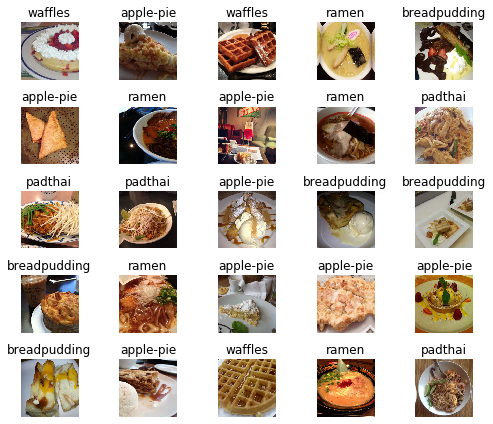

In [11]:
#let's take a look at our delicious food! Yummm....
data.show_batch(rows=5, figsize=(7,6))

In [64]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['apple-pie', 'breadpudding', 'padthai', 'ramen', 'waffles'], 5, 800, 200)

# Training 

Convolutional Neural Networks (http://cs231n.github.io/convolutional-networks/) are very similar to ordinary Neural Networks but the assumption is that the inputs are images- they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. Activation functions are applied to each node to capture non linearities in the data.

We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. We are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 5 outputs).

In [65]:
#model name is learn
learn = cnn_learner(data, models.resnet34, metrics=[error_rate])

In [66]:
my_model = learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.936209,0.832438,0.260000,00:26
1,1.310953,0.742622,0.200000,00:17
2,0.980479,0.767517,0.225000,00:17
3,0.792069,0.750119,0.215000,00:17


In [2]:
from azureml.core import Experiment, Run

#create new aml experiment 

experiment = Experiment(ws, 'fastai-food-classification')

In [46]:
from azureml.core.environment import CondaDependencies
from azureml.core import Environment


myenv = Environment(name="myenv")
conda_dep = CondaDependencies()


conda_dep.add_pip_package("fastai")
conda_dep.add_pip_package("ipykernel")
myenv.python.conda_dependencies=conda_dep

azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 50000000000
    

#To submit a run, create a run configuration that combines the script file and environment, and pass it to Experiment.submit. 
#In this example, the script is submitted to local computer, but you can specify other compute targets such as remote clusters as well.


#instead of managing the setup of the environment yourself, you can ask the system to build a new conda environment for you. 
#The environment is built once, and will be reused in subsequent executions as long as the conda dependencies remain unchanged.

myenv.python.user_managed_dependencies = False
    
runconfig = ScriptRunConfig(source_directory=".", script="train.py")
runconfig.run_config.target = "local"
runconfig.run_config.environment = myenv
run = experiment.submit(config=runconfig)

run.wait_for_completion(show_output=True)

RunId: fastai-food-classification_1582602259_c596a86a
Web View: https://ml.azure.com/experiments/fastai-food-classification/runs/fastai-food-classification_1582602259_c596a86a?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/pipelinesusabilitystudy/workspaces/shwinneworkshop

Streaming azureml-logs/60_control_log.txt

Streaming log file azureml-logs/60_control_log.txt

Streaming azureml-logs/70_driver_log.txt

Starting the daemon thread to refresh tokens in background for process with pid = 40205
Entering Run History Context Manager.
Preparing to call script [ train.py ] with arguments: []
After variable expansion, calling script [ train.py ] with arguments: []

█
epoch     train_loss  valid_loss  accuracy  time    
█
█
0         1.785787    1.083026    0.735000  00:11     
█
█
1         1.196665    0.893533    0.750000  00:08     
█
█
█
█
█
█
█
█
█
█
Accuracy:  0.7749999761581421


The experiment completed successfully. Finalizing run...
Logging experiment final

{'runId': 'fastai-food-classification_1582602259_c596a86a',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-02-25T03:46:58.478019Z',
 'endTimeUtc': '2020-02-25T03:47:50.443341Z',
 'properties': {'_azureml.ComputeTargetType': 'local',
  'ContentSnapshotId': '57e557b4-a00c-45ec-9014-dfe4bb08069f'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'local',
  'dataReferences': {},
  'data': {},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCount': 1,
  'environment': {'name': 'myenv',
   'version': 'Autosave_2020-02-25T03:31:01Z_032f0153',
   'python': {'interpreterPath': 'python',
    'userManagedDependencies': False,
    'condaDependencies': {'channels': ['conda-forge'],
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults', 'fastai', 'ipykernel']}],
     'name': 'azureml_fee5e6a92

In [44]:
from azureml.widgets import RunDetails 
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [41]:
%%writefile train.py
#
from fastai.vision import (ImageDataBunch, get_transforms, cnn_learner, models, imagenet_stats, accuracy)
#from fastai.metrics import error_rate
from pathlib import Path 
from azureml.core.run import Run 
import numpy as np

# get the Azure ML run object
run = Run.get_context()
def main():
    # get images
    path = Path('data')
    np.random.seed(2)
    data = ImageDataBunch.from_folder(path,
                                       train=".",
                                       valid_pct=0.2,
                                       ds_tfms=get_transforms(),
                                       size=224).normalize(imagenet_stats)
    # build estimator based on ResNet 34
    learn = cnn_learner(data, models.resnet34, metrics=accuracy)
    learn.fit_one_cycle(2)
    # do test time augmentation and get accuracy
    acc = accuracy(*learn.TTA())
    # log the accuracy to run`
    run.log('Accuracy', np.float(acc))
    print("Accuracy: ", np.float(acc))
    # save model
    learn.path = Path("./outputs")
    learn.export()
if __name__ == "__main__":
    main()



Overwriting train.py


In [45]:
%%writefile train.py

from fastai.vision import (ImageDataBunch, get_transforms, cnn_learner, models, imagenet_stats, accuracy)
#from fastai.metrics import error_rate
from pathlib import Path 
from azureml.core.run import Run 
import numpy as np

# get the Azure ML run object
run = Run.get_context()

    # get images
path = Path('data')
np.random.seed(2)
data = ImageDataBunch.from_folder(path,
                                       train=".",
                                       valid_pct=0.2,
                                       ds_tfms=get_transforms(),
                                       size=224).normalize(imagenet_stats)
    # build estimator based on ResNet 34
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(2)
    # do test time augmentation and get accuracy
acc = accuracy(*learn.TTA())
    # log the accuracy to run`
run.log('Accuracy', np.float(acc))
print("Accuracy: ", np.float(acc))
    # save model
learn.path = Path("./outputs")
learn.export()


Overwriting train.py


In [49]:
# Define remote compute target to use
# Further docs on Remote Compute Target: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-remote

# Choose a name for your cluster.
amlcompute_cluster_name = "gpu-cluster"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets

if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
     found = True
     print('Found existing training cluster.')
     # Get existing cluster
     # Method 1:
     aml_remote_compute = cts[amlcompute_cluster_name]
     # Method 2:
     # aml_remote_compute = ComputeTarget(ws, amlcompute_cluster_name)
    
if not found:
     print('Creating a new training cluster...')
     provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D13_V2", # for GPU, use "STANDARD_NC12"
                                                                 #vm_priority = 'lowpriority', # optional
                                                                 max_nodes = 20)
     # Create the cluster.
     aml_remote_compute = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
aml_remote_compute.wait_for_completion(show_output = True, min_node_count = 0, timeout_in_minutes = 20)
    
# For a more detailed view of current AmlCompute status, use get_status().

Found existing training cluster.
Checking cluster status...
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [22]:
from azureml.train.estimator import Estimator

estimator = Estimator(source_directory='.',
                      entry_script='train.py',
                      compute_target=amlcompute_cluster_name,
                      use_gpu=True,
                      pip_packages=['fastai'])

In [84]:
    #Next, we construct an `azureml.train.dnn.PyTorch` estimator object.\n",
    #"The PyTorch estimator provides a simple way of launching a PyTorch training job on a compute target. \n",
    #"The training script, 'fastai_train.py', is already created for you in the same folder as this tutorial, and we'll submit it using the `entry_script` parameter. We'll designate the gpu-cluster we created above as our `compute target`. \n",
#    "Since fastai v1 is built on top of PyTorch 1.0, we can use the `framework_version` parameter to specify our PyTorch version, and the estimator will automatically retrieve a Docker image that has PyTorch 1.0 and its dependencies installed.\n",
 
 #"Finally, on top of our PyTorch base image, we'll add the fastai v1 and pillow packages using the `pip_packages` parameter. The pillow package is necessary for image processing, and we'll pin to versions below 7.0.0 since those are known to be compatible with PyTorch 1.0's torchvision package."

#pillow's latest version is not compatible with the latest version of fastAI
#framework version - we want to install pytorch version 1.0 only works with fastai version 1 
from azureml.train.dnn import PyTorch

estimator = PyTorch(source_directory=".",
                            compute_target="gpu-cluster",
                            entry_script='train.py',
                            framework_version='1.0',
                            pip_packages=['fastai', 'pillow<7'])

In [85]:
azureml._restclient.snapshots_client.SNAPSHOT_MAX_SIZE_BYTES = 500000000000
run = experiment.submit(estimator)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/fast-ai/code/Users/fastai-on-aml directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [86]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [85]:
#exported to the data folder where - This method only works with the Learner whose data was created through the data block API.
learn.export('trained_model.pkl')

In [67]:
# Save the model to the outputs directory for capture. Note: this is not registering model
from azureml.core import Experiment
import joblib
model_file_name = 'outputs/trained_model.pkl'

joblib.dump(value = my_model, filename = model_file_name)

# upload the model file explicitly into artifacts 
run.upload_file(name = model_file_name, path_or_stream = model_file_name)


In [48]:
#Register the model
from azureml.core.model import Model

# register the model1.pkl file provided in the output folder 
model = Model.register(model_path = "outputs/trained_model.pkl", # this points to a local file
                       model_name = "food_classification_model", # this is the name the model is registered as
                       tags = {'food': "Yummmm :)"},
                       description = "Model predicting types of food",
                       workspace = ws)

print(model.name, model.description, model.version)


Registering model food_classification_model
food_classification_model Model predicting types of food 4


Prepare to deploy
To deploy the model, you need the following items:

1) An entry script, this script accepts requests, scores the requests by using the model, and returns the results.
2) Dependencies, like helper scripts or Python/Conda packages required to run the entry script or model.
3) The deployment configuration for the compute target that hosts the deployed model. This configuration describes things like memory and CPU requirements needed to run the model.

1. Define your entry script and dependencies
Entry script
We will first write the entry script as shown below. Note a few points in the entry script.

The script contains two functions that load and run the model:

init(): Typically, this function loads the model into a global object. This function is run only once, when the Docker container for your web service is started.

When you register a model, you provide a model name that's used for managing the model in the registry. You use this name with the Model.get_model_path() method to retrieve the path of the model file or files on the local file system. If you register a folder or a collection of files, this API returns the path of the directory that contains those files.

run(input_data): This function uses the model to predict a value based on the input data. Inputs and outputs of the run typically use JSON for serialization and deserialization. You can also work with raw binary data. You can transform the data before sending it to the model or before returning it to the client.

In [59]:
%%writefile score.py
#work in progress - CURRENTLY THIS DOES NOT WORK 

import fastai 
from fastai.vision import *
import joblib
import json
import pathlib
from pathlib import Path
import numpy as np
import torch


from azureml.core.model import Model


def init():
    global model
    # note here "food_classification_model" is the name of the model registered under the workspace, this call should return the path to the model.pkl file on the local disk
    model_path = Model.get_model_path('food_classification_model')
   # model = joblib.load(model_path)
    #We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.
    model = load_learner(model_path)  
    
def run(input_data):

    # get input data images
    image_path = Path(input_data)    
   # img = open_image(path/'apple-pie'/'3068872.jpg')      
    pred_class,pred_idx,outputs = model.predict(img_path)
    pred_class
    return pred_class
    
    


Overwriting score.py


It returns a tuple of three things: the object predicted (with the class in this instance), the underlying data (here the corresponding index) and the raw probabilities. You can also do inference on a larger set of data by adding a test set. This is done by passing an ItemList to load_learner.

learn = load_learner(mnist, test=ImageList.from_folder(mnist/'test'))
https://docs.fast.ai/tutorial.inference.html

Automatic schema generation
WHAT IS THE AUTOMATIC SCHEMA GENERATION FOR IMAGES?
To automatically generate a schema for your web service, provide a sample of the input and/or output in the constructor for one of the defined type objects. The type and sample are used to automatically create the schema. Azure Machine Learning then creates an OpenAPI (Swagger) specification for the web service during deployment. To use schema generation, include the inference-schema package in your Conda environment file.

Define dependencies
The following YAML is the Conda dependencies file we will use for inference. If you want to use automatic schema generation, your entry script must import the inference-schema packages.

In [43]:
%%writefile myenv.yml

name: project_environment
dependencies:
- python=3.6.2

- pip:
  - fastai
  - azureml-defaults
  - azureml-core
  - joblib==0.14.1
  - matplotlib==3.1.2
- numpy
- pillow<7


Overwriting myenv.yml


In [44]:
from azureml.core import Environment

# Instantiate environment
myenv = Environment.from_conda_specification(name = "myenv",
                                             file_path = "myenv.yml")

Define your inference configuration The inference configuration describes how to configure the model to make predictions. This configuration isn't part of your entry script. It references your entry script and is used to locate all the resources required by the deployment. It's used later, when you deploy the model.


In [45]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(entry_script='score.py', environment=myenv)

Define your deployment configuration Before deploying your model, you must define the deployment configuration. The deployment configuration is specific to the compute target that will host the web service. The deployment configuration isn't part of your entry script. It's used to define the characteristics of the compute target that will host the model and entry script.

In [46]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags = {'task': "image-classification"}, 
                                               description='A model to predict types of food')

Deployment uses the inference configuration deployment configuration to deploy the models. The deployment process is similar regardless of the compute target

In [60]:
service = Model.deploy(ws, name='image-classification-fastai7', models=[model], inference_config= inference_config, deployment_config=aciconfig)
service.wait_for_deployment(True)
print(service.state)

Running.............................................................................................................................................................................................................................
TimedOut


Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 164e553f-71bc-4ece-aa4d-e91ee4c6b3c8
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice."
}

Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 164e553f-71bc-4ece-aa4d-e91ee4c6b3c8
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our no

WebserviceException: WebserviceException:
	Message: Service deployment polling reached non-successful terminal state, current service state: Unhealthy
Operation ID: 164e553f-71bc-4ece-aa4d-e91ee4c6b3c8
More information can be found using '.get_logs()'
Error:
{
  "code": "DeploymentTimedOut",
  "statusCode": 504,
  "message": "The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice."
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service deployment polling reached non-successful terminal state, current service state: Unhealthy\nOperation ID: 164e553f-71bc-4ece-aa4d-e91ee4c6b3c8\nMore information can be found using '.get_logs()'\nError:\n{\n  \"code\": \"DeploymentTimedOut\",\n  \"statusCode\": 504,\n  \"message\": \"The deployment operation polling has TimedOut. The service creation is taking longer than our normal time. We are still trying to achieve the desired state for the web service. Please check the webservice state for the current webservice health. You can run print(service.state) from the python SDK to retrieve the current state of the webservice.\"\n}"
    }
}

In [53]:
service.get_logs()
#get or list all services from ws class 

'2020-02-28T01:35:52,195304704+00:00 - iot-server/run \n2020-02-28T01:35:52,194292194+00:00 - gunicorn/run \n2020-02-28T01:35:52,210925155+00:00 - rsyslog/run \n2020-02-28T01:35:52,224051681+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_954f1dba07fbf347b589279fda3386b4/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_954f1dba07fbf347b589279fda3386b4/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_954f1dba07fbf347b589279fda3386b4/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_954f1dba07fbf347b589279fda3386b4/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_954f1dba07fbf347b589279fda3386b4/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

In [113]:
#THIS NOT WORKING
import json
import pandas as pd

# the sample below contains the data for an employee that is not an attrition risk
sample = open_image(path/'apple-pie'/'3068872.jpg') 

# converts the sample to JSON string
sample = pd.DataFrame.to_json(sample)

# deserializes sample to a python object 
sample = json.loads(sample)

# serializes sample to JSON formatted string as expected by the scoring script
sample = json.dumps({"data":sample})



prediction = service.run(sample)

print(prediction)

NotImplementedError: 'obj' should be a Series or a DataFrame

In [100]:
#This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model
learn.export()

#test model on cpu
defaults.device = torch.device('cpu')

img = open_image(path/'apple-pie'/'3068872.jpg')
img
type(img)

fastai.vision.image.Image

In [121]:
pred_class,pred_idx,outputs = learn.predict(img)
outpus



tensor(0)